<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Laplace_On_Disc/LaplaceOnDisc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import jax.random as random
import jax.numpy as jnp
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
def poisson_kernel(r, theta):
  return ((1 - jnp.power(r, 2)) / 
          (1 - 2 * r * jnp.cos(theta) + jnp.power(r, 2)))

In [45]:
'''
solve_at_point : Solves the Dirichlet problem for Laplace's equation on a 2D 
disc at polar coordinates (r, theta). Also takes the boundary condition as a
parameter.

Parameters
--------------------
g : the boundary condition as a vectorized function
k : the kernel function of the integral equation as a vectorized function
r : the radius of the polar coordinates as a single number
theta : the angle of the polar coordinates as a single number
n_samples : the number of samples of E[g(X)] where X ~ P(theta - phi)
t : the number of discrete time steps of the Metropolis-Hastings algorithm to
sample from X
key : the key to use for randomness

Returns : the solution to the Dirichlet problem for Laplace's equation on a 2D
disc at the given point with the given boundary condition

Notes
--------------------
Currently, we want to use the Poisson kernel P(theta), so set k as 
poisson_kernel(r)

P(theta) = (1 - r^2) / (1 - 2*r*cos(theta) + r^2)
'''
def solve_at_point(g, k, r, theta, n_samples, t, key):
  # generate keys
  keys = random.split(key, 3)

  # sample from X ~ P(theta - phi) with Metropolis-Hastings
  # create initial guess with Q(x'|x) as a uniform distribution over the domain
  current_samples = random.uniform(keys[0], shape=(1, n_samples)) * 2 * jnp.pi

  # create proposed states to move to
  proposals = random.uniform(keys[1], shape=(t, n_samples)) * 2 * jnp.pi

  # generate uniform r.v.
  U = random.uniform(keys[2], shape=(t, n_samples))

  # keep a running estimate of g(X)
  G = g(current_samples)

  # run markov chain over time
  for i in range(t):
    # compute acceptance probabilities
    A = k(r, theta - proposals[i]) / k(r, theta - current_samples)
    A = jnp.minimum(1, A)
    # move or don't move states based on A and U
    new_samples = jnp.where(U[i] <= A, proposals[i], current_samples)
    # add and update mean and samples
    current_samples = new_samples
    G = G + (g(current_samples) - G) / (i+2)

  # compute E(g(X))
  return jnp.mean(G)

In [50]:
n_samples = 100
t = 10000
r = 0.5
theta = jnp.pi / 2
key = random.PRNGKey(int(time.time()))
ans = solve_at_point(jnp.sin, poisson_kernel, r, theta, n_samples, t, key)
ans

DeviceArray(0.50043654, dtype=float32)

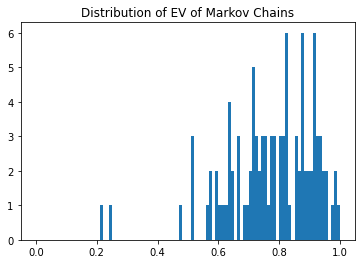

In [42]:
# plot distibution of EV of markov chains
G = jnp.sin(mean)
plt.hist(G, jnp.arange(0, 1.01, 0.01))
plt.title("Distribution of EV of Markov Chains")
plt.show()

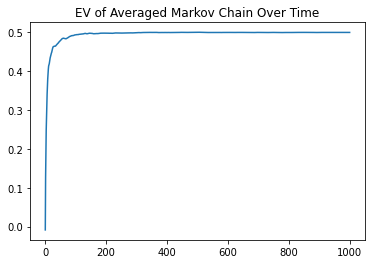

In [ ]:
# plot EV of markov chains over time
E_over_time = jnp.cumsum(jnp.mean(G, axis=1)) / jnp.arange(1, t+2)
plt.plot(E_over_time)
plt.title("EV of Averaged Markov Chain Over Time")
plt.show()

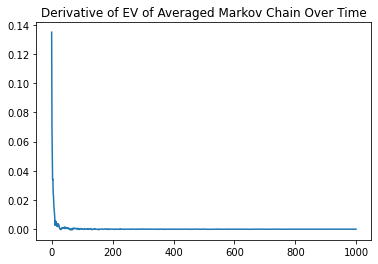

In [ ]:
dE_over_time = jnp.diff(E_over_time)
plt.plot(dE_over_time)
plt.title("Derivative of EV of Averaged Markov Chain Over Time")
plt.show()

In [ ]:
'''
solve_at : Solves the Dirichlet problem for Laplace's equation on a 2D disc at
given vectors of r and theta. Also takes the boundary condition as a
parameter.

Parameters
--------------------
g : the boundary condition as a vectorized function
k : the kernel function of the integral equation as a vectorized function
r : the radius of the polar coordinates as a column vector
theta : the angle of the polar coordinates as a column vector
n_samples : the number of samples of E[g(X)] where X ~ P(theta - phi)
t : the number of discrete time steps of the Metropolis-Hastings algorithm to
sample from X
key : the key to use for randomness

Returns : the solution to the Dirichlet problem for Laplace's equation on a 2D
disc at the given point with the given boundary condition

Notes
--------------------
Currently, we want to use the Poisson kernel P(theta), so set k as 
poisson_kernel(r)

P(theta) = (1 - r^2) / (1 - 2*r*cos(theta) + r^2)
'''
def solve_at(g, k, r, theta, n_samples, t, key):
  keys = random.split(key, 2);

  x = random.uniform(keys[0], shape=(1,t)) * 2 * np.pi
  f = k(r, theta - x)
  
  A1 = jnp.tile(jnp.transpose(f), (1,t))
  A2 = jnp.tile(1/f, (t,1))
  
  A = jnp.minimum(1, jnp.tril(jnp.multiply(A1, A2), k=-1))

  u = jnp.tril(random.uniform(keys[1], shape=(t,t)), k=-1)
  
  check = jnp.subtract(A, u)
    
  col = 0
  y = np.zeros(t)
  for i in range(t):
      if check[i+1,col] >= 0:
          y[i] = x[1,col]
          col += 1
      else:
          y[i] = x[1,col]

  return y, jnp.mean(g(jnp.asarray(y)))

In [ ]:
n_samples = 1000
t = 10000
r = 0.8
theta = jnp.pi / 2
key = random.PRNGKey(0)
samples, ans = solve_at(jnp.sin, poisson_kernel, r, theta, n_samples, t, key)
ans

DeviceArray(0.41911498, dtype=float32)

In [ ]:
ans

DeviceArray(0.6244727, dtype=float32)